In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F

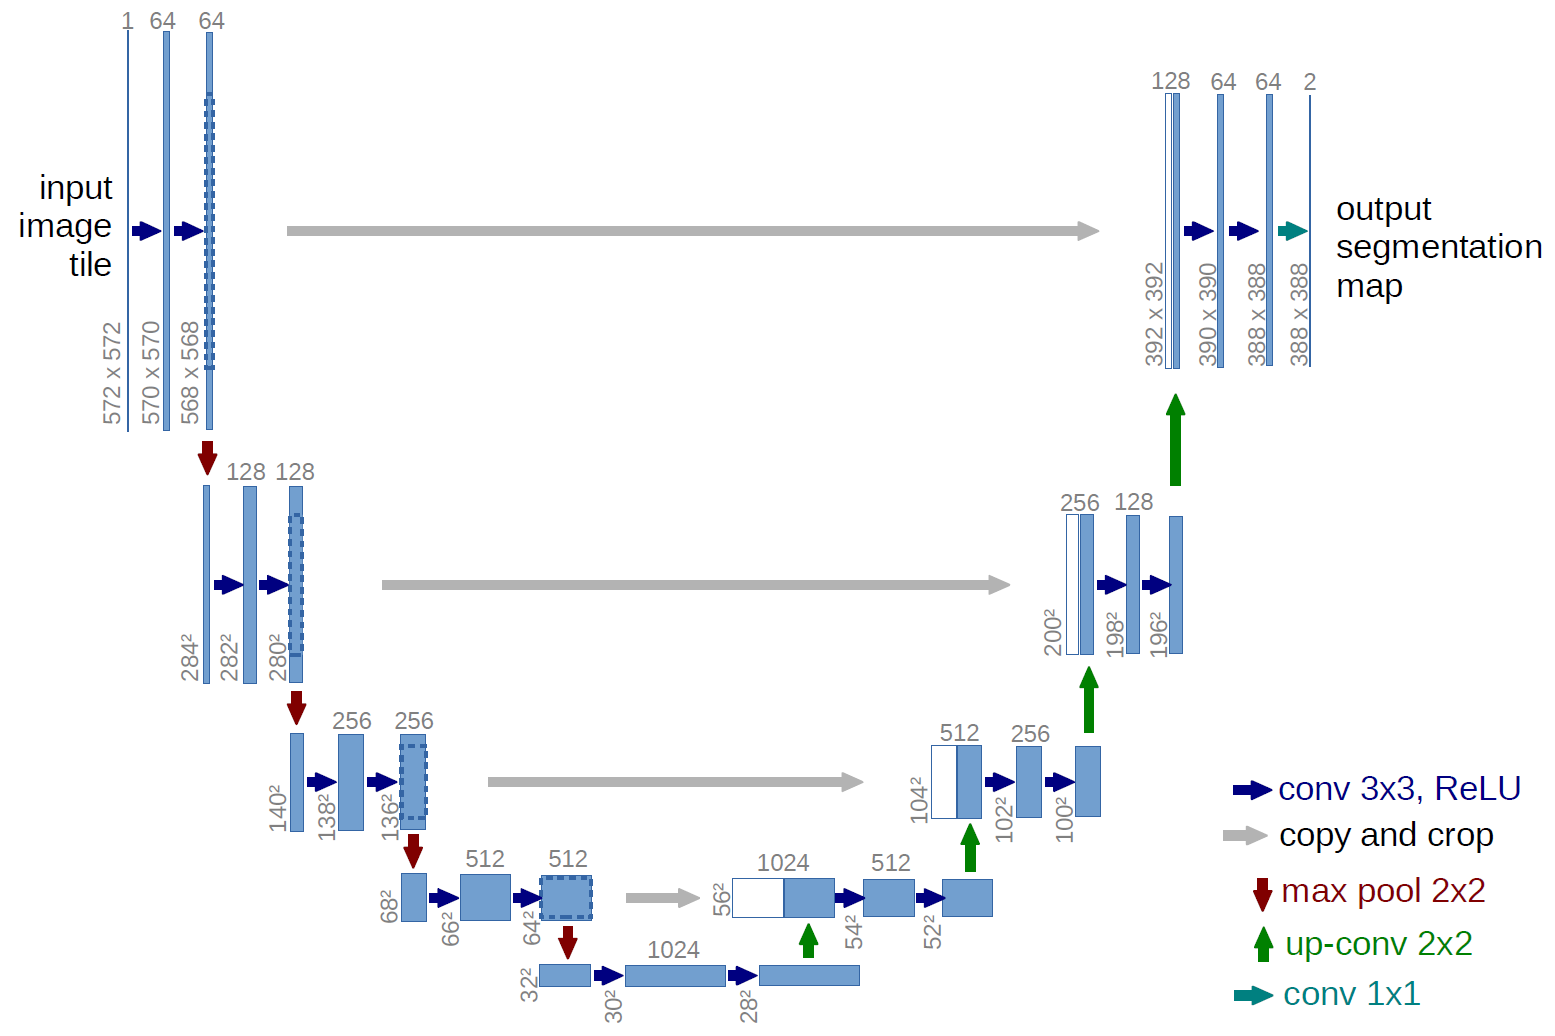

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)

    )
  def forward(self, x):
    return self.conv(x)

In [9]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)
  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

In [12]:
class UNET2D(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super().__init__()
    self.down_samplings = nn.ModuleList()
    self.down_samplings.append(DoubleConv(in_channels, features[0]))
    for feature in features:
      self.down_samplings.append(
          nn.Sequential(
              nn.MaxPool2d(kernel_size=2, stride=2),
              DoubleConv(feature, feature*2)
          )
      )
    self.up_samplings = nn.ModuleList()
    for feature in reversed(features):
      self.up_samplings.append(
          Decoder(feature*2, feature)
      )
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []
    for down_sampling in self.down_samplings:
      x = down_sampling(x)
      skip_connections.append(x)
    skip_connections = skip_connections[:-1][::-1]
    for i in range(len(self.up_samplings)):
      x = self.up_samplings[i](x, skip_connections[i])

    return self.final_conv(x)

ex = torch.rand((1, 3, 160, 160))
model = UNET2D()
print(model(ex).shape)



torch.Size([1, 1, 160, 160])


## 3d UNET

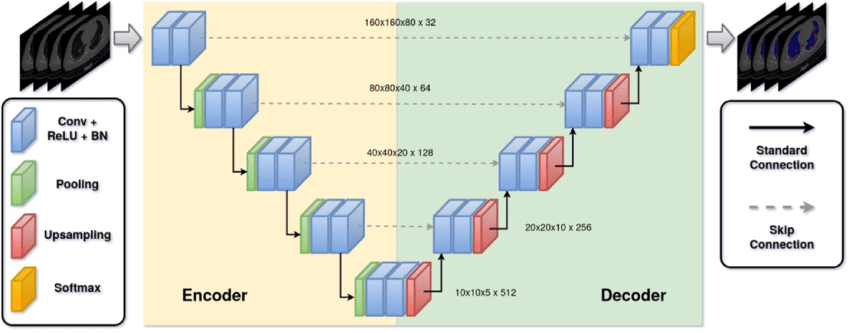

In [ ]:
class DownSampingDouble3DCNN(nn.Module):
    def __init__(self, in_channels=None, out_channels=None, bottleneck=False) -> None:
        super(DownSampingDouble3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels=out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    def forward(self, x):
        residual = self.relu(self.bn1(self.conv1(x)))
        residual = self.relu(self.bn2(self.conv2(residual)))
        out = residual
        if not self.bottleneck:
            out = self.pooling(residual)
        return out, residual

class UpsamplingDouble3DCNN(nn.Module):
    def __init__(self, in_channels=None, res_channels=0, out_channels=None, last_layer=False, num_classes=None):
        super(UpsamplingDouble3DCNN, self).__init__()
        self.last_layer = last_layer
        self.num_classes = num_classes

        self.upconv1 = nn.ConvTranspose3d(
            in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm3d(num_features=in_channels)
        self.bn2 = nn.BatchNorm3d(num_features=in_channels // 2)
        self.conv1 = nn.Conv3d(
            in_channels=in_channels + res_channels,
            out_channels=in_channels,
            kernel_size=(3,3,3),
            padding=1)
        self.conv2 = nn.Conv3d(
            in_channels=in_channels, out_channels=in_channels // 2, kernel_size=(3,3,3), padding=1)
        if self.last_layer:
            self.conv3 = nn.Conv3d(
                in_channels=in_channels // 2,
                out_channels=num_classes,
                kernel_size=(1,1,1))

    def forward(self, x, residual=None):
        out = self.upconv1(x)

        if residual is not None:
            if out.shape[2:] != residual.shape[2:]:
                residual = F.interpolate(
                    residual,
                    size=out.shape[2:],
                    mode='trilinear',
                    align_corners=False)

            out = torch.cat([out, residual], dim=1)

        out = self.relu(self.bn1(self.conv1(out)))
        out = self.relu(self.bn2(self.conv2(out)))

        if self.last_layer:
            out = self.conv3(out)
        return out

class Unet3D(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, num_features=[64, 128, 256, 512]):
        super(Unet3D, self).__init__()
        self.downsamplings = nn.ModuleList()
        self.upsamplings = nn.ModuleList()

        # Down sampling path
        for i in range(len(num_features) - 1):
            self.downsamplings.append(DownSampingDouble3DCNN(in_channels=in_channels if i == 0 else num_features[i-1],
                                                              out_channels=num_features[i]))

        # Bottleneck
        self.bottleneck = DownSampingDouble3DCNN(in_channels=num_features[-2], out_channels=num_features[-1], bottleneck=True)

        # Up sampling path
        for i in range(len(num_features) - 1, 0, -1):
            self.upsamplings.append(
                UpsamplingDouble3DCNN(in_channels=num_features[i], res_channels=num_features[i-1],
                                      out_channels=num_features[i-1])
            )

        self.last_layer = UpsamplingDouble3DCNN(in_channels=num_features[0], res_channels=0,
                                                last_layer=True, num_classes=num_classes)

    def forward(self, x):
        residuals = []

        # Down sampling path
        for downsampling_layer in self.downsamplings:
            x, residual = downsampling_layer(x)
            residuals.append(residual)

        x, _ = self.bottleneck(x)

        # Up sampling path
        for idx, upsampling_layer in enumerate(self.upsamplings):
            x = upsampling_layer(x, residual=residuals[-idx-1])

        x = self.last_layer(x)
        return x

# Create the model
model = Unet3D()

# Dummy input
input = torch.randn(1, 3, 64, 64, 64)  # (batch_size, channels, depth, height, width)

# Forward pass
output = model(input)
print(output.shape)